# Example 1a: Set up of an event subset of aftershocks

In this example we will estimate relative moment tensors for a rather small subset of aftershock seismicity related to the 2016 M6.6 Muji earthquake in the Pamir highlands of Central Asia. The first notebook illustrates how to set up the input files for *relMT*.

This notebook relies on the results of the previous example. Please execute it before running this notebook.

In [1]:
from relmt import io, mt, utils, extra, core

from pathlib import Path
from warnings import filterwarnings
from IPython.display import Image, display # trick to show files in notebook

import matplotlib.pyplot as plt
from obspy import read_events, UTCDateTime, Inventory, Stream
from obspy.clients.fdsn import Client


# The networks considered here
nets = ["8H", "9H"]

def netcode(stacode):
    """Network code of station"""
    # All 8H stations start with "EP"
    if stacode.startswith("EP"):
        return "8H"
    # All 9H stations that are not 8H have a "6" at the end
    if stacode[-1] == "6":
        return "9H"
    # We do not consider the other networks present
    return ""


## Initialize the project

We begin by initializing the folder structure though a call to `relmt init`. Let's call the project like the mainshock: "muji", and see what was created using `ls`. In the following lines, the exclamation mark `!` indicates that the commands are run on the command line, using the shell as a interpreter. Indeed, *relMT* is intended to be used directly from the terminal.

In [2]:
! relmt init muji
! ls muji/*

muji/config.yaml  muji/exclude.yaml

muji/align1:

muji/align2:

muji/amplitude:

muji/data:
default-hdr.yaml

muji/result:


We see the configuration file *config.yaml* and the exclude file *exclude.yaml*. The directories *data/*, *align1/*, *align2/*, *amplitude/* and *result/* will be populated while we work on the project.

In this example we will start from scratch. This means we will create the necessary files from raw seismograms and arrival time picks, as it is often the case when starting a new project.

## Extraction of the event and MT subsets
Let us assume we would be interested in learning about the structure of the fault zone in between the two asperities that broke in the 2016 M6.6 Muji earthquake. Consider Fig. 6 of [Bloch et al. (2023, GJI)](https://doi.org/10.1093/gji/ggac473). We here want to work on the event subset marked by the bright red circle:

![Project overview](https://raw.githubusercontent.com/wasjabloch/relMT-data/main/example/Bloch_2023_Fig6.png)

Two full moment tensors are available. There is more seismicity, occurring before as well as after the main shock. Let us extract the events that are located within 5 km from the largest aftershocks. From the figure we can see that the two events for which we have an MT available are located between 39.15˚N and 39.3˚N and 74.1˚E and 74.6˚E. Let's see where we find those events in the MT file

In [3]:
! awk '$3 > 74.1 && $3 < 74.6 && $4 > 39.15 && $4 < 39.3 {print NR, $1, $2, $3, $4, $5, $6}' ext/2022-007_Bloch-et-al_moment_tensor_catalog_correct_norm_v2.0.txt

25 2016/11/25 19:46:20 74.29494 39.19792 6 4.2
26 2016/11/26 09:23:27 74.27384 39.20200 6 5.0


The events occurred on the 25. and 26. November 2016 and had magnitudes of 4.2 and 5.0. The first column indicates that we find the events in the 28th and 29th line of the provided MT file (1-based indexing). Remember that the input file has 4 header lines and Python uses 0-based indexing. That means, we are looking for the MTs at position 23 and 24 in the relMT file. 

In [4]:

# Input files
evinf = "data/events.txt"
mtinf = "data/reference_mts.txt"

# Indices of reference events (0-based indexing)
irefs = [23, 24]

evd = io.read_event_table(evinf)
mtd = io.read_mt_table(mtinf)

refids = [list(mtd)[i] for i in irefs]

print("The reference events are: ", refids)
for refid in refids:
    print(f"Event {refid} ({evd[refid].name}): Mw {mt.magnitude_of_vector(mtd[refid]):.2f}")

The reference events are:  [7508, 7640]
Event 7508 (20161125194617): Mw 4.17
Event 7640 (20161126092323): Mw 4.95


The event times and magnitudes in the catalog agree with the one in the MT file. We have selected the correct events.

Let us find the events that are within 5km of Event 7640 and save them to the project directory.

In [5]:

# The event coordinates are the first three elements of the event tuple
xyz0 = evd[7640][:3]

dist = 5000  # m

iin = [
    evn for evn, ev in evd.items() if utils.cartesian_distance(*xyz0, *ev[:3]) < dist
]

evsub = {evn: evd[evn] for evn in iin}
mtsub = {evn: mtd[evn] for evn in mtd if evn in iin}

print(f"We have selected {len(evsub)} events.")
print(f"There are {len(mtsub)} reference MTs in the dataset.")

# Save everything to file
_ = io.write_event_table(evsub, "muji/data/events.txt")
_ = io.write_mt_table(mtsub, "muji/data/reference_mts.txt")


We have selected 167 events.
There are 2 reference MTs in the dataset.


## Creation of a phase file

The phase file contains the arrival times and take-off angles of the seismic phases at a seismic station. We will here create it from the QuakeML file available in the [supplementary material of Bloch et al. (2023)](https://doi.org/10.5880/fidgeo.2022.007) using *ObsPy*.

In [6]:
# QuakeML file containing all arrival time pics
pickf = "ext/2026-006_Bloch-et-al_2015-2017_pamir_catalog_bulletin.xml"

print("Reading event catalog... This may take a while.")

# Load them into an ObsPy Catalog
cat = read_events(pickf)

Reading event catalog... This may take a while.


We now extract the event subset and only consider data from the 8H and 9H networks for this example.

In [7]:
# Event subset
catsub = [cat[evn] for evn in evsub]

# Pick subset
npick = 0
picked = set()
for iev, ev in enumerate(catsub):
    print(f"Processing event {iev} of {len(catsub)}...   ", end="\r")
    ev.picks = [pick for pick in ev.picks if netcode(pick.waveform_id.station_code) in nets]
    npick += len(ev.picks)
    
    # Stations with picks
    picked = picked.union([pick.waveform_id.station_code for pick in ev.picks])

print(f"We extracted {npick} arrival time picks on {len(picked)} stations")

# Save phases in relMT format
phd = extra.read_catalog_picks(catsub, evsub)
tab = io.write_phase_table(phd, "muji/data/phases.txt")

# And have a look
! head muji/data/phases.txt

We extracted 2343 arrival time picks on 39 stations
#     EventIndex Station Phase        Arrivaltime  Azimuth      Plunge
#          (int)   (str) (P/S)          (seconds) (degree)    (degree)
             338    EP07     P  1446295343.390000      nan         nan
             338    EP03     P  1446295346.120000      nan         nan
             338    EP04     P  1446295346.540000      nan         nan
             338    EP04     S  1446295357.500000      nan         nan
             338    EP14     P  1446295352.840000      nan         nan
             338    EP23     P  1446295356.280000      nan         nan
             338    EP15     P  1446295358.470000      nan         nan
             338    EP20     P  1446295361.780000      nan         nan


This pick catalog is incomplete in two ways. First, there may not be picks for all events on all stations. Second, we are missing take-off angles. Before we can proceed, we need to download station data.


## Download station data

We can now go ahead and download the waveform data. More information on the networks can be found on [fdsn.org](https://www.fdsn.org/):

* [8H (2018-2017): East Pamir seismic network](https://www.fdsn.org/networks/detail/8H_2015/)
* [9H (2016-2017): Sarez Pamir aftershock seismic network](https://www.fdsn.org/networks/detail/9H_2016/)

We'll use *ObsPy* to download the station data from the respective FDSN clients, and then convert the retrieved `Inventory` object to a *relMT* station file.

In [8]:
inv = Inventory()
client = Client("GEOFON")
for net in nets:
    inv += client.get_stations(
        network=net,
        level="response",
        starttime=UTCDateTime(2015, 9, 1),
        endtime=UTCDateTime(2017, 12, 31),
    )

As *relMT* works in local Cartesian coordinates, we need to transform the stations coordinates into the same system as the event locations in the previous example.

In [9]:

# Geoconverter for UTM zone 43S (Pamir region)
def geoconverter(lat, lon, dep):
    return extra.geoconverter_latlon2utm(lat, lon, dep, 43, "S")

# Convert the ObsPy inventory to a relMT station dictionary

# NB: Station BRC6 was moved by ~100m during the experiment and is present twice
# in the Inventory. Setting strict=False uses only the first occurrence.
std = extra.read_station_inventory(inv, geoconverter, strict=False)

# Only keep stations for which we have picks
std = {code: station for code, station in std.items() if code in picked}

# Save to the project directory
tab = io.write_station_table(std, "muji/data/stations.txt")

# This is the station table
! head muji/data/stations.txt

#Station     Northing      Easting       Depth
# (code)      (meter)      (meter)     (meter) 
    EP01  4375757.146   624124.779   -1238.000
    EP02  4409262.275   549835.334   -2098.000
    EP03  4392894.695   482129.742   -2110.000
    EP04  4412986.946   444406.952   -2505.000
    EP05  4396699.595   412675.102   -2774.000
    EP06  4363097.960   543617.884   -1458.000
    EP07  4353255.540   494802.762   -2557.000
    EP08  4316868.602   449992.662   -3505.000



## Add missing data to the phase dictionary 

### Arrival times
We can approximately estimate the arrival times of missing picks, by interpolating the travel times of missing stations.

In [10]:
phd_interp = utils.interpolate_phase_dict(phd, evsub, std)

print(f"Interpolated phases: {len(phd_interp)}")

phd.update(phd_interp)

Interpolated phases: 11356



### Take-off angles
To estimate take-off angles, we need a velocity model. We download the 1D starting model of [Bloch et al (2021)](https://doi.org/10.1029/2021GL095413).

In [11]:
! wget -nc -nv -P ext https://raw.githubusercontent.com/wasjabloch/relMT-data/main/example/vmodel_1d_simul.txt


Next we use it to do ray tracing, where we internally use the same algorithm as [SKHASH (Skoumal et al. 2024)](https://doi.org/10.1785/0220230329).

In [12]:
# The downloaded velocity model file
vmodelf = "ext/vmodel_1d_simul.txt"

# Load into numpy array
vmodel = io.read_velocity_model(vmodelf)

# Plunge is calculated in the 1D velocity model
phd = utils.phase_dict_hash_plunge(phd, evd, std, vmodel)

# Take-off azimuth is calculated with trigonometry
phd = utils.phase_dict_azimuth(phd, evd, std)

# Save updated phase table
_ = io.write_phase_table(phd, "muji/data/phases.txt")

# ... and have a look
! head muji/data/phases.txt


#     EventIndex Station Phase        Arrivaltime  Azimuth      Plunge
#          (int)   (str) (P/S)          (seconds) (degree)    (degree)
             338    EP07     P  1446295343.390000    77.74      -17.82
             338    EP03     P  1446295346.120000    41.97      -14.78
             338    EP04     P  1446295346.540000     7.57      -14.00
             338    EP04     S  1446295357.500000     7.57      -14.00
             338    EP14     P  1446295352.840000   141.07       -5.51
             338    EP23     P  1446295356.280000    85.38       -2.77
             338    EP15     P  1446295358.470000   151.35        2.13
             338    EP20     P  1446295361.780000   114.95        3.37


## Add event, station and phase file to the config
Now that we have created the event, station and phase files for this event, let's add them to the configuration file, so that the programs can access them. Note that this mechanism allows us to play, for example, with different event locations or take-off angles. Note that the file paths are relative to the project directory (here "muji"). In practice, we would open a text editor and write into `muji/config.yaml`.

In [13]:
conf = io.read_config("muji/config.yaml")

# Input files
# -----------
#
# Path to the seismic event catalog, e.g. 'data/events.txt'
conf["event_file"] = "data/events.txt"

# Path to the station location file, e.g. 'data/stations.txt'
conf["station_file"] = "data/stations.txt"

# Path to the phase file, e.g. 'data/phases.txt'
conf["phase_file"] = "data/phases.txt"

# Path to the reference moment tensor file, e.g. 'data/reference_mt.txt'
conf["reference_mt_file"] = "data/reference_mts.txt"

# File paths are relative to the project directory
conf.to_file("muji/config.yaml", overwrite=True)

## Download the waveform data

We will now go through the subset seismic event catalog and will download generous time windows from 5 seconds before the origin time until 10s after the last pick, for all stations for which picks are available. The streams will be saved to disc to simulate files that are located on a local file system. In a second step, the phase wave trains will be cut out and written to the waveform arrays.

We will be downloading about 656 MB of seismic data.

In [14]:
# Ignore warnings to not clutter output
filterwarnings("ignore")

# The waveform download directory
wvd = Path("ext")

# Initialize FDSN client.
client = Client("GEOFON")

# Now download the data
for evn, ev in evsub.items():

    # Origin time
    t0 = UTCDateTime(ev.time)

    # File name
    wvf = wvd / f"{evn}.mseed"
    print(f"Working on: {wvf}...   ", end="\r")

    # Skip existing files
    if wvf.exists():
        print(f"{wvf} exists. Continuing with next event.", end="\r")
        continue

    # Stations that have picks for this event
    stas = set(
        [
            core.split_phaseid(phid)[1]
            for phid in phd
            if core.split_phaseid(phid)[0] == evn
        ]
    )

    # Latest pick time for this event
    tmax = max(
        [
            phase.time
            for phid, phase in phd.items()
            if core.split_phaseid(phid)[0] == evn
        ]
    )

    # Start time for this event
    t1 = t0 - 5

    # End time for this event (10 seconds after latest pick)
    t2 = UTCDateTime(tmax) + 10

    # Set of networks relevant to this event
    evnets = set([netcode(sta) for sta in stas if netcode(sta) in nets])

    stream = Stream()
    for net in evnets :

        try:
            # Append downloaded waveforms to stream
            stream += client.get_waveforms(
                net, "*", "*", "?H?", starttime=t1, endtime=t2, attach_response=True
            )
        except Exception as exc:
            # Be generous with exceptions in this example
            print(f"I met the exception:\n {exc.__repr__()}. Continuing.")
            continue

    if not stream:
        print(f"No data for event {evn}. Continuing.")
        continue

    # Remove instrument response in case instrument or gain has changed over
    # time. This step is not required if the instrument was not changed.
    stream.remove_response()

    # Save to disk
    stream.write(wvf)

## Creating waveform headers and arrays

### Header files
We will first create the *relMT* [header files](https://relmt.readthedocs.io/en/latest/formats/file_formats.html#waveform-header-files-station-phase-hdr-yaml) and later read the meta data from those. This ensures that all data and meta data are consistent. We will first define a default header with a general configuration that is suitable for most stations. We will then set special time windows required for the closest stations.

In [15]:
# Define a default header
def_hdr = core.Header(
    phase_start=-1.0,  # 1s before pick
    phase_end=5.0,  # 5s after pick
    taper_length=1.0,  # 1second taper (combined at both ends)
    highpass=1 / 2,  # 0.5 Hz high-pass filter
    lowpass=2,  # 2 Hz low-pass filter
    sampling_rate=100,  # 100 Hz sampling frequency
    data_window=12.25,  # 12.25s data window
    components="ZNE",  # Vertical, North, East seismometer components
)

# The header files follow an internal naming convention that is implemented in
# core.file()
hdrfn = core.file("waveform_header", directory="muji")
def_hdr.to_file(hdrfn, True)

print("Default header written to: ", hdrfn)

Default header written to:  muji/data/default-hdr.yaml


Some stations are located close to the cluster of seismic events. During the event processing, it becomes important that only energy of the specified seismic phase type (*P* or *S*) is present in the data window. The 12.25 s data window is too long for *P* phases on the closest seismic stations. Let us make a quick plot to see which stations are closest to the cluster.

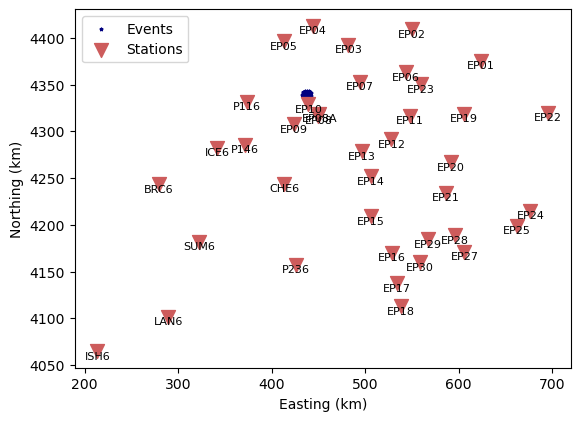

In [16]:
# Coordinate arrays of stations and events
evxyz = utils.xyzarray(evsub) * 1e-3  # km
stxyz = utils.xyzarray(std) * 1e-3  # km
stnames = list(std.keys())

# Set up a figure
fig, ax = plt.subplots()
ax.set_aspect("equal")

# Event locations
ax.scatter(evxyz[:, 1], evxyz[:, 0], c="navy", marker="*", s=5, label="Events")

# Station locations
ax.scatter(stxyz[:, 1], stxyz[:, 0], c="indianred", marker="v", s=100, label="Stations")

# Station names
for stxy, stname in zip(stxyz[:, [1, 0]], stnames):
    ax.text(*stxy, stname, fontsize=8, ha="center", va="top")

_ = ax.legend()
_ = ax.set_xlabel("Easting (km)")
_ = ax.set_ylabel("Northing (km)")

Let's write out the 5 closest stations. The first four of those require special treatment:

In [17]:
# Distance from cluster centroid to stations
dists = utils.cartesian_distance(
    *evxyz.mean(axis=0), stxyz[:, 0], stxyz[:, 1], stxyz[:, 2]
)
idist = dists.argsort()

n = 5
print(f"The {n} closest stations are:")
for i in range(n):
    print(f"{stnames[idist[i]] :5s}: {dists[idist[i]]:.1f} km")

The 5 closest stations are:
EP10 : 14.3 km
EP08A: 26.4 km
EP08 : 27.2 km
EP09 : 35.8 km
EP07 : 59.6 km


We next define special data windows for the four closest stations. They are based on analyst experience on working with the data set at hand.

We then extract the waveform identifiers present in the phase dictionary. A waveform identifier refers to a combination of a station and a phase type and are characterized by a similar waveform.

In [18]:
# Special data windows
specialdw = {"EP10": 3.15, "EP08A": 6.25, "EP08": 6.25, "EP09": 6.5}

# Unique wave IDs in the phase dictionary
wvids = sorted(set(core.join_waveid(*core.split_phaseid(phid)[1:]) for phid in phd))
for wvid in wvids:

    # Station and phase
    sta, pha = core.split_waveid(wvid)

    # Initialize header
    hdr = core.Header()

    # Set station name and phase
    hdr["station"], hdr["phase"] = sta, pha

    # Apply special data window if needed
    if pha == "P" and sta in specialdw:
        hdr["data_window"] = specialdw[sta]
        hdr["phase_end"] = (specialdw[sta] - def_hdr["taper_length"] - 0.1) / 2
        hdr["highpass"] = 1  # Shorter time window requires higher highpass

    hdrf = core.file("waveform_header", sta, pha, directory="muji")
    hdr.to_file(hdrf, overwrite=True)

    print(f"Header for waveform {wvid} written to: {hdrf}   ", end="\r")
print("Done writing headers.                                           ")

Done writing headers.                                           


## Construct the waveform arrays

[The waveform arrays](https://relmt.readthedocs.io/en/latest/formats/file_formats.html#waveform-array-files-station-phase-wvarr-npy) hold the waveform data and are central to *relMT*. They are of shape `(events, channels, samples)`. The dimensions must be in agreement with the values of the header values `"events_"`, `"channels"`, `"data_window"` and `"sampling_rate"`.

We now set up the waveform array for each seismic station and phase in the data set. We loop through the header files we just created. The `"events_"` keyword needs special attention because each seismic station in general recorded a different set of events.

In [19]:
from numpy import save
from obspy import read
from pathlib import Path

# Project directory
projdir = "muji"

# Waveform directory
wvdir = Path("ext")

# Load MiniSEED wavforms into ObsPy Stream
stream = read(wvdir / "*.mseed")

# Unique wave IDs in the phase dictionary
wvids = sorted(set(core.join_waveid(*core.split_phaseid(phid)[1:]) for phid in phd))

# Default values are read from the default header file
default_hdrf = core.file("waveform_header", directory=projdir)

for wvid in wvids:
    print(f"Processing waveform {wvid}...", end="\r")

    # Station and phase
    sta, pha = core.split_waveid(wvid)

    # core.file implements the naming convention for relMT files
    hdrf = core.file("waveform_header", sta, pha, directory=projdir)
    arrf = core.file("waveform_array", sta, pha, directory=projdir)

    # Read the header, filling in defaults where necessary
    hdr = io.read_header(hdrf, default_hdrf)

    wvarr, hdr = extra.make_waveform_array(hdr, phd, stream)

    # Waveform arrays are conventional .npy files
    save(arrf, wvarr)

    # We write the specific waveform header
    hdr.to_file(hdrf, overwrite=True)

# List the created waveform array files
! ls muji/data/*-wvarr.npy

muji/data/BRC6_P-wvarr.npy   muji/data/EP16_P-wvarr.npy
muji/data/BRC6_S-wvarr.npy   muji/data/EP16_S-wvarr.npy
muji/data/CHE6_P-wvarr.npy   muji/data/EP17_P-wvarr.npy
muji/data/CHE6_S-wvarr.npy   muji/data/EP18_P-wvarr.npy
muji/data/EP01_P-wvarr.npy   muji/data/EP18_S-wvarr.npy
muji/data/EP01_S-wvarr.npy   muji/data/EP19_P-wvarr.npy
muji/data/EP02_P-wvarr.npy   muji/data/EP19_S-wvarr.npy
muji/data/EP02_S-wvarr.npy   muji/data/EP20_P-wvarr.npy
muji/data/EP03_P-wvarr.npy   muji/data/EP21_P-wvarr.npy
muji/data/EP03_S-wvarr.npy   muji/data/EP21_S-wvarr.npy
muji/data/EP04_P-wvarr.npy   muji/data/EP22_P-wvarr.npy
muji/data/EP04_S-wvarr.npy   muji/data/EP22_S-wvarr.npy
muji/data/EP05_P-wvarr.npy   muji/data/EP23_P-wvarr.npy
muji/data/EP05_S-wvarr.npy   muji/data/EP24_P-wvarr.npy
muji/data/EP06_P-wvarr.npy   muji/data/EP24_S-wvarr.npy
muji/data/EP06_S-wvarr.npy   muji/data/EP25_P-wvarr.npy
muji/data/EP07_P-wvarr.npy   muji/data/EP25_S-wvarr.npy
muji/data/EP07_S-wvarr.npy   muji/data/EP27_P-wv

## Conclusion

In this example we extracted an event subset from a large earthquake catalog and downloaded station and waveform data from publicly accessible repository. Let's have a look at the *P* waveform recorded on station *EP05*:

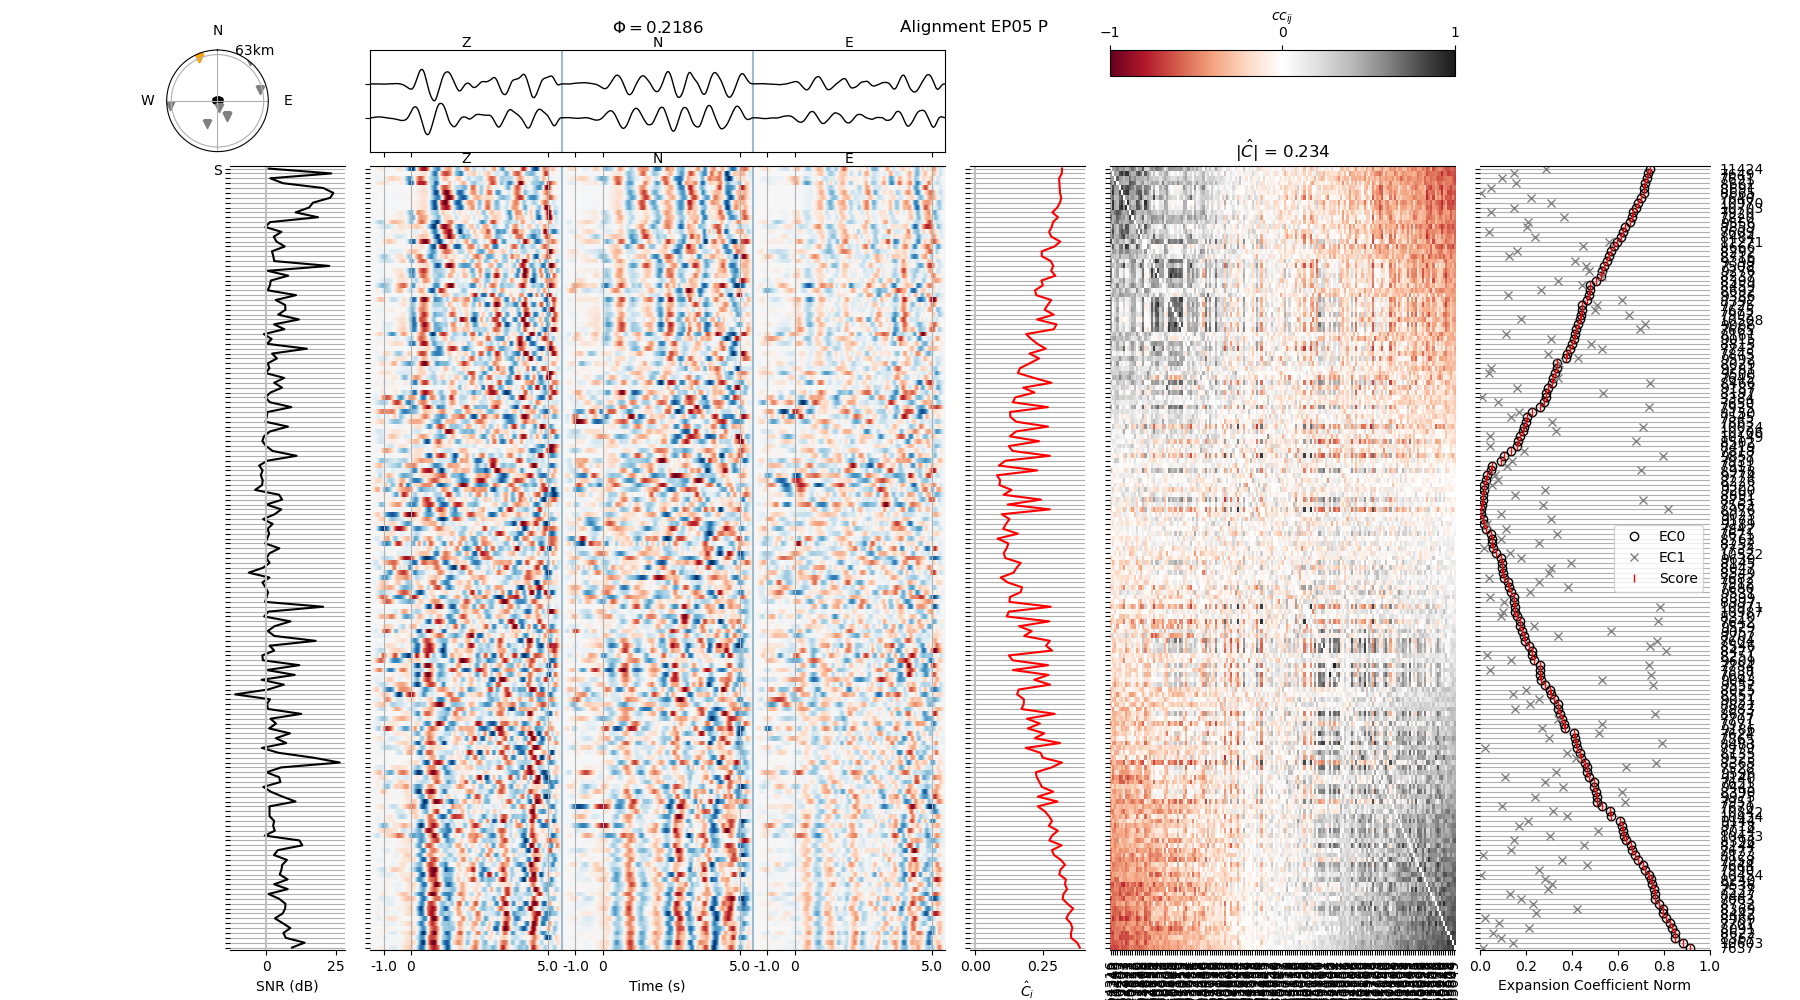

In [20]:
# Plot an example waveform alignment
# On the command line, one can omit the --saveas option to show an interactive plot
! relmt plot-alignment muji/data/EP05_P-wvarr.npy -c muji/config.yaml --saveas tmp.png

# Show and clean up in the notebook
display(Image("tmp.png"))
! rm tmp.png